---

# Descripción de proyecto

En este proyecto vamos a realizar un test A/B sobre las ventas de una tienda en línea,

Junto con el departamento de marketing __se ha recopilado una lista de hipótesis que pueden ayudar a aumentar los ingresos. Vamos a priorizar estas hipótesis, lanzar un test A/B y analizar los resultados__.

Trabajaremos con datos provenientes de las ventas y las visitas realizadas a la tienda en línea.

# Cargar librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import scipy.stats as stats

sns.set_palette(palette='tab10')

# Cargar datos

In [2]:
data_hypotheses = pd.read_csv('/datasets/hypotheses_us.csv',sep=';')

In [3]:
data_hypotheses.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 1.6 KB


In [4]:
# mostramos las hipótesis y sus parámetros
pd.set_option('display.max_colwidth', 120)
data_hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


In [5]:
# reestablecemos el ancho de las columnas
pd.set_option('display.max_colwidth', 50)

Descripción de los datos:

* __Hypotheses:__ breves descripciones de las hipótesis

* __Reach__: alcance del usuario, en una escala del uno a diez

* __Impact__: impacto en los usuarios, en una escala del uno al diez

* __Confidence__: confianza en la hipótesis, en una escala del uno al diez

* __Effort__: los recursos necesarios para probar una hipótesis, en una escala del uno al diez. Cuanto mayor sea el valor Effort, más recursos requiere la prueba.

In [6]:
# cargamos los datos de las ventas
data_orders = pd.read_csv('/datasets/orders_us.csv',parse_dates=['date'])

In [7]:
# revisamos información general de 'data_orders'
data_orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 105.3 KB


In [8]:
# mostramos parte de los datos
data_orders.sample(3)

,transactionId,visitorId,date,revenue,group
772,2309036559,2908466434,2019-08-05,30.2,B
644,3664867609,1476256851,2019-08-26,25.5,A
737,1061639574,2195309755,2019-08-09,50.5,B


In [9]:
# mostramos las categorias en la columna 'group'
data_orders['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

Descripción de los datos:

* __transactionId__: identificador de pedido
* __visitorId__: identificador del usuario que realizó el pedido
* __date__: fecha del pedido, en formato AAAA-MM-DD
* __revenue__: ingresos del pedido
* __group__: el grupo del test A/B al que pertenece el usuario

In [10]:
# cargamos los datos de las visitas a la tienda en linea
data_visits=pd.read_csv('/datasets/visits_us.csv',parse_dates=['date'])

In [11]:
# revisamos información general de 'data_visits'
data_visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 4.6 KB


In [12]:
# mostramos parte de los datos
data_visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [13]:
# mostramos las categorias en la columna 'group'
data_visits['group'].value_counts()

B    31
A    31
Name: group, dtype: int64

Descripción de los datos:

* __date__: la fecha, en formato AAAA-MM-DD
* __group__: grupo del test A/B
* __visits__: el número de visitas en la fecha especificada para el grupo de test A/B especificado

# Parte 1. Priorizar hipotesis

## Framework ICE

En el archivo 'data_hypotheses' tenemos nueve hipótesis sobre como aumentar los ingresos de una tienda en línea con Reach, Impact, Confidence y Effort, especificados para cada una. __Aplicaremos el framework ICE y RICE para priorizar hipótesis.__

In [14]:
# echamos un vistazo a 'data_hypotheses'
data_hypotheses.sample()

,Hypothesis,Reach,Impact,Confidence,Effort
5,Add a customer review page. This will increase...,3,2,2,3


In [15]:
# calculamos el 'ICE score'
data_hypotheses['ICE']=data_hypotheses.Impact*data_hypotheses.Confidence/data_hypotheses.Effort

In [16]:
# ordenamos por el valor 'ICE'
pd.set_option('display.max_colwidth', 120)
data_hypotheses.sort_values('ICE',ascending=False)

,Hypothesis,Reach,Impact,Confidence,Effort,ICE
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.200000
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.333333
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.200000
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.000000
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.000000
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.000000
5,Add a customer review page. This will increase the number of orders,3,2,2,3,1.333333
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.125000
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.000000


__Usando el parámetro 'ICE' tenemos que las hipótesis más prometedoras son la 8, 0, 7 y 6.__

## Framework RICE

In [17]:
# calculamos el 'RICE score'
data_hypotheses['RICE']=data_hypotheses.Reach*data_hypotheses.Impact*data_hypotheses.Confidence/data_hypotheses.Effort

In [18]:
# calculamos el 'RICE score'
data_hypotheses['RICE']=data_hypotheses.Reach*data_hypotheses.Impact*data_hypotheses.Confidence/data_hypotheses.Effort
# ordenamos por el valor 'RICE'
data_hypotheses.sort_values('RICE',ascending=False)

,Hypothesis,Reach,Impact,Confidence,Effort,ICE,RICE
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.200000,112.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.000000,56.0
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.333333,40.0
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.000000,40.0
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.200000,16.2
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.125000,9.0
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.000000,4.0
5,Add a customer review page. This will increase the number of orders,3,2,2,3,1.333333,4.0
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.000000,3.0


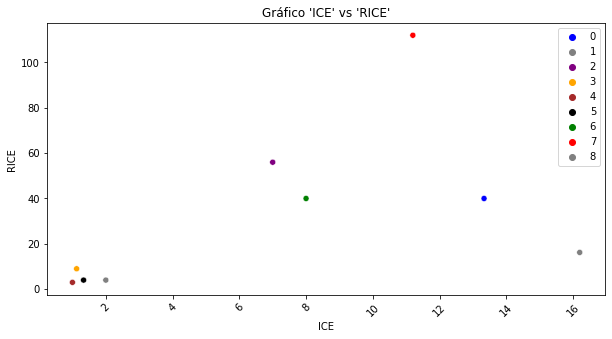

In [19]:
# creamos un gráfico de scatter para observar mejor el comportamiento de 'ICE' y 'RICE'
plt.subplots(figsize=(10,5))

# Trazar el gráfico de 'ICE' vs 'RICE'
colores=['blue','gray','purple','orange','brown','black','green','red','gray']
sns.scatterplot(data=data_hypotheses,x='ICE',y='RICE',hue=data_hypotheses.index,palette=colores)
plt.title("Gráfico 'ICE' vs 'RICE'")
#plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.show()

__Según el parámetro 'RICE', se identificaron las hipótesis más prometedoras para el grupo de marketing. Estas hipótesis, que ocupan los primeros puestos tanto en el framework 'ICE' como en 'RICE', son la 7, 2, 0 y 6. Se considera lógico que la adición de una lista de correos electrónicos nos permita enviar ofertas por correo electrónico__, así como mostrar recomendaciones de productos y agregar nuevos canales de tráfico para atraer a nuevos clientes.

Entre estas hipótesis, la número 7 destaca por su alto alcance y el potencial impacto que tiene en los usuarios. Sin embargo, las hipótesis 0 y 6 también son importantes en términos de impacto. Se observa que la hipótesis 7 se posiciona como la mejor evaluada en el gráfico que compara 'ICE' y 'RICE'. Esto indica que esta hipótesis tiene un alto potencial para llegar a un gran número de usuarios, lo cual es relevante para el grupo de marketing.

__En conclusión, para el grupo de marketing, se recomienda considerar la adición de una forma de suscripción en la página principal con el objetivo de obtener una lista de correos electrónicos. Esto permitirá ampliar el alcance y tener un mayor impacto en los usuarios, según las hipótesis más prometedoras identificadas mediante el análisis de 'RICE'.__

In [20]:
# reestablecemos el ancho de las columnas
pd.set_option('display.max_colwidth', 50)

# Parte 2 TEST A/B

Preprocesamiento de los datos

In [21]:
# revisamos las caracteristicas de los grupos
data_visits['group'].value_counts()

B    31
A    31
Name: group, dtype: int64

In [22]:
# revisamos las caracteristicas de los grupos
data_orders['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

Podemos observar que no hay valores nulos en ninguno de los set de datos.

Aseguremonos que cada uno de los clientes que realizaron una compra aparece en uno solo de los grupos, para poder decir que los resultados de la prueba A/B serán válidos.

In [23]:
# obtenemos la lista de los clientes del grupo A
list_clientsA=data_orders[data_orders['group']=='A']['visitorId'].unique()
list_clientsA.shape

(503,)

In [24]:
# obtenemos la lista de los clientes del grupo B
list_clientsB=data_orders[data_orders['group']=='B']['visitorId'].unique()
list_clientsB.shape

(586,)

In [25]:
#creamos dos conjuntos con los 'visitorId' de cada grupo y buscamos su intersección para ver los usuarios que aparecen en ambos conjuntos

set1 = set(list_clientsA)
set2 = set(list_clientsB)

set3 = set1 & set2

# usuarios en ambos grupos
list_clientsAB = list(set3)
print(f'Hay {len(list_clientsAB)} usuarios que aparecen en ambos grupos.')

Hay 58 usuarios que aparecen en ambos grupos.


In [26]:
# verifiquemos que efectivamente esos usuarios aparecen en ambos grupos
data_orders[data_orders['visitorId'].isin(list_clientsAB)].sort_values('visitorId').head(10)

,transactionId,visitorId,date,revenue,group
703,4293855558,8300375,2019-08-07,30.5,A
71,3679129301,8300375,2019-08-01,165.7,B
823,2971973105,199603092,2019-08-27,45.9,A
246,437656952,199603092,2019-08-02,55.7,B
26,2223239646,199603092,2019-08-15,55.7,A
134,62794304,199603092,2019-08-22,110.3,A
1102,1941707234,199603092,2019-08-12,100.0,A
1009,2670069237,232979603,2019-08-31,45.6,B
1013,83566152,232979603,2019-08-31,5.9,A
590,3702128013,237748145,2019-08-20,20.8,A


In [27]:
# veamos cuantas compras fueron realizadas por estos usuarios
data_orders[data_orders['visitorId'].isin(list_clientsAB)].shape

(181, 5)

Tenemos 181 compras realizadas por los 58 usuarios que aparecen en ambos grupos. Vamos a eliminar estas compras realizadas por estos usuarios para que los resultados de la prueba A/B sean válidos.

In [28]:
# creamos un set de datos de las compras sin las compras realizadas por los usuarios pertenecientes a ambos grupos
data_orders_AB=data_orders[~data_orders['visitorId'].isin(list_clientsAB)].copy()

In [29]:
# revisamos el tamaño del dataframe creado
data_orders_AB.shape

(1016, 5)

# Ingresos acumulados por grupo

In [30]:
# creamos una matriz con valores únicos de parejas fecha-grupo
dates_group=data_orders_AB[['date','group']].drop_duplicates()

In [31]:
data_orders_AB

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A


In [32]:
# obtenemos los ingresos diarios acumulados
orders_aggregated = dates_group.apply(lambda x: data_orders_AB[np.logical_and(data_orders_AB['date'] <= x['date'],\
                                        data_orders_AB['group'] == x['group'])]\
                                      .agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique,\
                                            'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1)\
                                        .sort_values(by=['date','group'])
orders_aggregated.columns=['date','group','orders','buyers','revenue']

In [33]:
# obtenemos las visitas diarias acumuladas
visits_aggregated = dates_group.apply(lambda x: data_visits[np.logical_and(data_visits['date'] <= x['date'],\
                                    data_visits['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max',\
                                    'visits' : 'sum'}), axis=1).sort_values(by=['date','group'])
visits_aggregated.columns=['date','group','visits']

In [34]:
# fusionamos los ingresos acumulados con la tabla de visitas
cumulative_data = orders_aggregated.merge(visits_aggregated,on=['date','group'])
cumulative_data.sample()

,date,group,orders,buyers,revenue,visits
36,2019-08-19,A,299,283,32389.3,11629


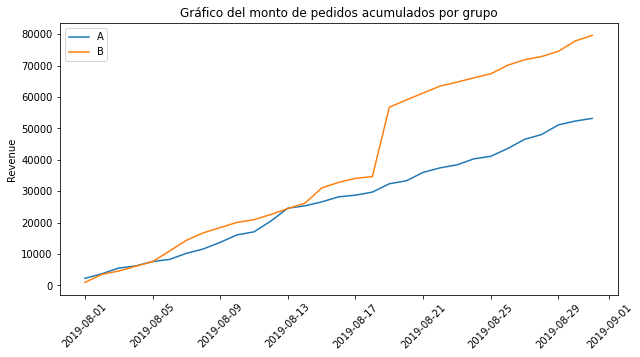

In [35]:
#Creamos el gráfico del monto de pedidos acumulados por grupo

# DataFrame con pedidos acumulados e ingresos acumulados por día, grupo A
cumulative_revenueA = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# DataFrame con pedidos acumulados e ingresos acumulados por día, grupo B
cumulative_revenueB = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

plt.subplots(figsize=(10,5))
# Trazar el gráfico de ingresos del grupo A
plt.plot(cumulative_revenueA['date'], cumulative_revenueA['revenue'], label='A')

# Trazar el gráfico de ingresos del grupo B
plt.plot(cumulative_revenueB['date'], cumulative_revenueB['revenue'], label='B')
plt.title('Gráfico del monto de pedidos acumulados por grupo')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Podemos notar en el gráfico anterior que los ingresos del grupo B tienen un cambio muy brusco en un punto de la gráfica. Lo que nos puede implicar un aumento en la cantidad de pedidos o de pedidos muy caros (valores extremos) en el grupo a partir de esa fecha. Los ingresos del grupo A parecen más estables.

# Tamaño de pedido promedio acumulado por grupo

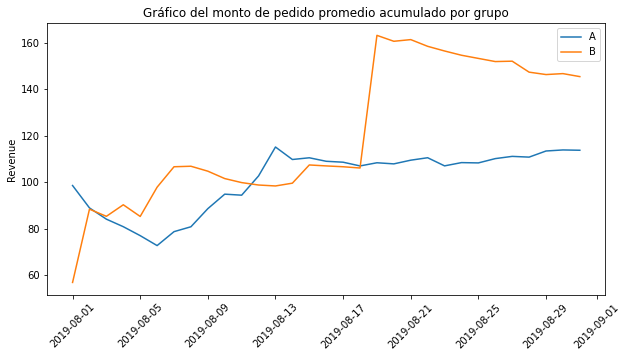

In [36]:
#Creamos el gráfico del monto promedio por grupo

plt.subplots(figsize=(10,5))

plt.plot(cumulative_revenueA['date'], cumulative_revenueA['revenue']/cumulative_revenueA['orders'], label='A')
plt.plot(cumulative_revenueB['date'], cumulative_revenueB['revenue']/cumulative_revenueB['orders'], label='B')
plt.title('Gráfico del monto de pedido promedio acumulado por grupo')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Según el gráfico previo, notamos que el grupo B experimentó un salto drástico en un punto específico y luego disminuyó nuevamente, lo que podría sugerir que hubo compras excepcionalmente costosas en esa fecha (valores atípicos). En cuanto al grupo A, el valor medio de compra parece haberse estabilizado alrededor de esas fechas. Sin embargo, el valor medio de compra para el grupo B aún no muestra signos de estabilidad, lo que indica que se requieren más datos para determinar este valor y establecer su nivel.

# Diferencia relativa en el monto de pedido promedio acumulado para el grupo B en comparación con el grupo A

Para crear el gráfico de diferencia relativa para los montos de compra promedio necesitamos reunir los set de datos que contienen los pedidos e ingresos acumulados por día para cada grupo, 'cumulative_revenueA' y 'cumulative_revenueB'.

In [37]:
# fusionamos los dataframe 'cumulative_revenueA' y 'cumulative_revenueB'
merged_cumulative_revenue = cumulative_revenueA.merge(cumulative_revenueB,on='date', how='left', suffixes=['A', 'B'])

In [38]:
# echamos un vistazo a los datos
merged_cumulative_revenue.sample()

,date,revenueA,ordersA,revenueB,ordersB
29,2019-08-30,52363.7,460,77863.5,531


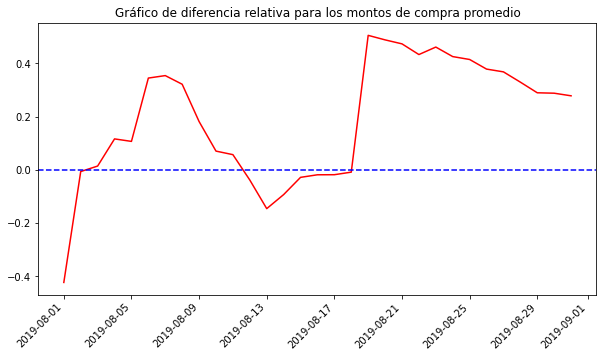

In [39]:
plt.subplots(figsize=(10,5))
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])\
         /(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1,color='red')
plt.title('Gráfico de diferencia relativa para los montos de compra promedio')

# agregamos una línea horizontal en y=0
plt.axhline(y=0, color='blue', linestyle='--')
plt.xticks(rotation=45,ha='right')
plt.show()

Podemos observar que no se ha alcanzado una estabilización en la diferencia relativa para los montos de compra promedio, pero que parece estar disminuyendo. Podemos optar por esperar a que el monto de compra promedio acumulado para el grupo B continúe disminuyendo o en su caso parar la prueba.

En varios puntos, la diferencia entre los segmentos aumenta. Puede ser que haya algunos pedidos muy grandes o valores atípicos.

# Tasa de conversión de cada grupo

In [40]:
cumulative_data

,date,group,orders,buyers,revenue,visits
0,2019-08-01,A,23,19,2266.6,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,42,36,3734.9,1338
3,2019-08-02,B,40,39,3535.3,1294
4,2019-08-03,A,66,60,5550.1,1845
...,...,...,...,...,...,...
57,2019-08-29,B,510,490,74576.7,17708
58,2019-08-30,A,460,437,52363.7,18037
59,2019-08-30,B,531,511,77863.5,18198
60,2019-08-31,A,468,445,53212.0,18736


In [41]:
# calculamos la tasa de conversión acumulada para cada grupo
cumulative_data['conversion']=cumulative_data['orders']/cumulative_data['visits']

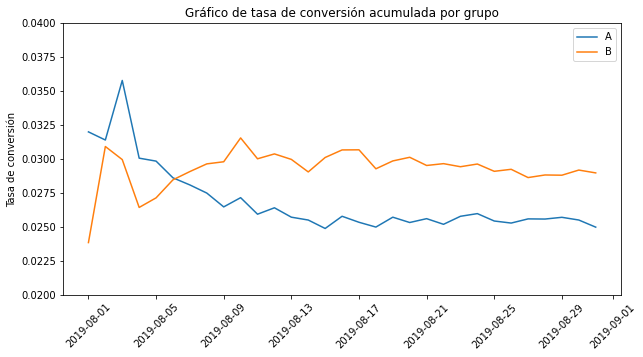

In [42]:
#Creamos el gráfico de tasa de conversión acumulada por grupo

# seleccionamos datos en el grupo A
cumulative_dataA = cumulative_data[cumulative_data['group']=='A']

# seleccionamos datos en el grupo B
cumulative_dataB = cumulative_data[cumulative_data['group']=='B']

plt.subplots(figsize=(10,5))
# trazar los gráficos
plt.plot(cumulative_dataA['date'], cumulative_dataA['conversion'], label='A')
plt.plot(cumulative_dataB['date'], cumulative_dataB['conversion'], label='B')
plt.title('Gráfico de tasa de conversión acumulada por grupo')
plt.legend()
plt.ylabel('Tasa de conversión')
plt.ylim( 0.02, 0.04)
plt.xticks(rotation=45)
plt.show()

Observamos fluctuaciones en la tasa de conversión acumulada para ambos grupos. Posiblemente como consecuencia de que haya días con demasiadas ordenes de compra. La tasa de conversión para ambos grupos parece estabilizarse.

# Diferencia relativa para las tasas de conversión acumuladas

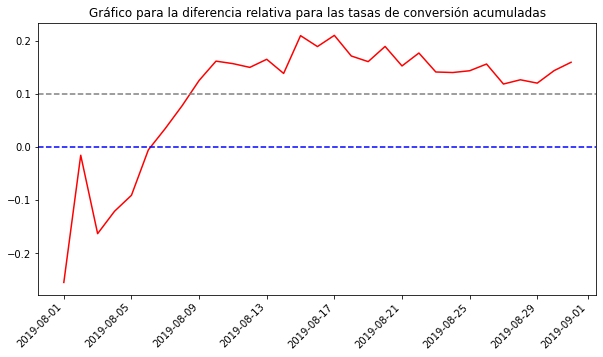

In [43]:
"""Creamos un gráfico para la diferencia relativa para las tasas de conversión acumuladas"""

merged_cumulative_conversions = cumulative_dataA[['date','conversion']]\
                                .merge(cumulative_dataB[['date','conversion']],on='date',\
                                how='left', suffixes=['A', 'B'])

plt.subplots(figsize=(10,5))
plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversionB']\
         /merged_cumulative_conversions['conversionA']-1,color='r')
plt.title('Gráfico para la diferencia relativa para las tasas de conversión acumuladas')
plt.axhline(y=0, color='blue', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.xticks(rotation=45,ha='right')
plt.show()

En general, el índice de conversión no es estable por lo que es demasiado pronto para sacar alguna conclusión. Observamos que hay un crecimiento sostenido de las conversiones del grupo B y que parecen estabilizarse después del 9 de agosto.

# Dispersión del número de pedidos por usuario

Vamos a seguir haciendo uso del dataframe 'data_orders_AB', que ya no tiene usuarios duplicados en los dos grupos.

In [44]:
# calculamos el número de pedidos por usuario
orders_by_user=data_orders_AB.groupby('visitorId',as_index=False).agg(orders=('transactionId','nunique'))

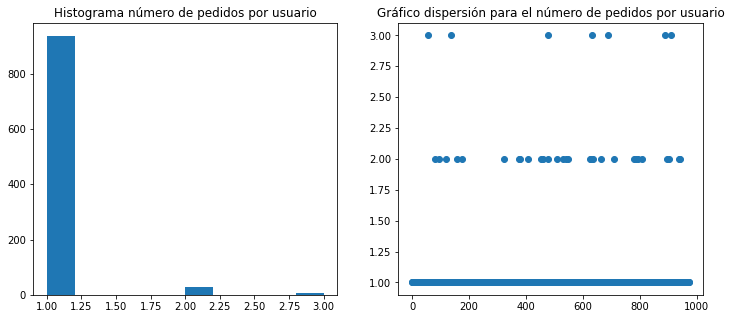

In [45]:
"""Creamos el histograma y el gráfico de dispersión para el número de pedidos por usuario"""
x_values = pd.Series(range(0,len(orders_by_user)))


fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))


ax1.set_title('Histograma número de pedidos por usuario')
ax1=orders_by_user['orders'].hist(ax=ax1,grid=False)

ax2.set_title('Gráfico dispersión para el número de pedidos por usuario')
ax2=plt.scatter(x_values, orders_by_user['orders'])

plt.show()

La mayoría de los usuarios realizan un solo pedido. Una parte significativa hizo de dos a tres pedidos cada uno.

In [46]:
# calculamos los percentiles para el número de pedidos por usuario
print(np.percentile(orders_by_user['orders'], [90, 95, 99]))

[1. 1. 2.]


No más del 5% realizaron más de un pedido y no más del 1% realizaron más de dos pedidos. Establezcamos entonces dos como el límite del número de pedidos por usuario y filtremos las anomalías en base a ello.

# Dispersión de los montos de los pedidos

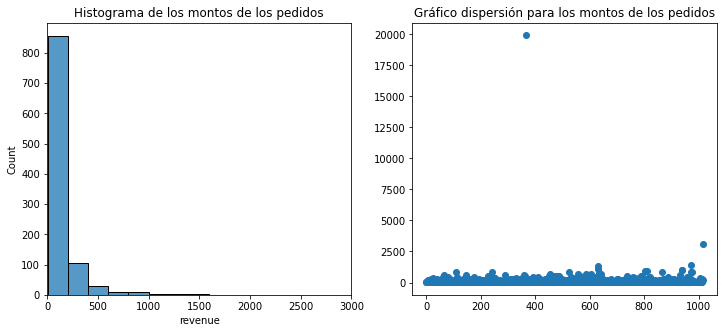

In [47]:
"""Creamos el histograma y el gráfico de dispersión para los montos de los pedidos"""
x_values = pd.Series(range(0,data_orders_AB.shape[0]))


fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))


ax1.set_title('Histograma de los montos de los pedidos')
ax1.set_xlim(0,3000)
ax1=sns.histplot(data_orders_AB['revenue'],bins=100,ax=ax1)

ax2.set_title('Gráfico dispersión para los montos de los pedidos')
ax2=plt.scatter(x_values, data_orders_AB['revenue'])

plt.show()

In [48]:
# mostramos los percentiles de los montos de los pedidos
print(np.percentile(data_orders['revenue'], [90, 95, 99]))

[282.48  435.54  900.904]


In [49]:
# mostramos las estadisticas para los montos de los pedidos
data_orders['revenue'].describe()

count     1197.000000
mean       131.491646
std        603.004729
min          5.000000
25%         20.800000
50%         50.200000
75%        130.400000
max      19920.400000
Name: revenue, dtype: float64

No más del 5% de los pedidos suman un monto de 435.54 y no más del 1% son superiores a 900.904. Vamos a establecer 435 como el límite del monto de un pedido y filtraremos las anomalías en base a ello. El gráfico nos permite observar claramente que existen valores extremos en 'revenue'.

# Significancia estadística de la diferencia en las tasas de conversión entre los grupos utilizando los datos en bruto

Para calcular la significancia estadística en las tasas de conversión vamos a crear dos dataframe para almacenar la cantidad de pedidos por usuario. Emplearemos la prueba U de Mann-Whitney.

Supuestos en la prueba U de Mann-Whitney:

1.La variable dependiente debe medirse a nivel ordinal o continuo.

2.La variable independiente debe consistir en dos grupos.

3.Debe haber independencia de las observaciones de cada grupo.

Esto significa que no hay relación entre las observaciones de cada grupo o entre los propios grupos.Por ejemplo, debe haber diferentes participantes en cada grupo y ningún participante debe estar en más de un grupo. Este problema se solucionó en la etapa de preprocesamiento quitando los usuarios que aparecían en ambos grupos.

1. Las dos variables se distribuyen de forma anormal.

# La prueba U de Mann-Whitney puede utilizarse cuando las dos variables no se distribuyen de forma regular.

Probaremos la hipótesis nula:

__H0: Las medias de la cantidad de compras en los grupos A y B son iguales__

__HA: Las medias de la cantidad de compras en los grupos A y B no son iguales__

In [50]:
# creamos un dataframe para el grupo 'A' conteniendo los pedidos por usuario
orders_by_usersA = data_orders_AB[data_orders_AB['group']=='A'].groupby('visitorId', as_index=False)\
                    .agg({'transactionId' : pd.Series.nunique})
orders_by_usersA.columns = ['visitorId', 'orders']

In [51]:
# para los usuarios que no hicieron pedidos tendrán un cero
# creamos la muestra para el grupo 'A'
sampleA = pd.concat([orders_by_usersA['orders'],\
                     pd.Series(0, index=np.arange(data_visits[data_visits['group']=='A']['visits'].sum() - \
                                                  len(orders_by_usersA['orders'])), name='orders')],axis=0)

In [52]:
# creamos un dataframe para el grupo 'B' conteniendo los pedidos por usuario
orders_by_usersB = data_orders_AB[data_orders_AB['group']=='B'].groupby('visitorId', as_index=False)\
                    .agg({'transactionId' : pd.Series.nunique})
orders_by_usersB.columns = ['visitorId', 'orders']

In [53]:
# para los usuarios que no hicieron pedidos tendrán un cero
# creamos la muestra para el grupo 'B'
sampleB = pd.concat([orders_by_usersB['orders'],\
                     pd.Series(0, index=np.arange(data_visits[data_visits['group']=='B']['visits'].sum() - \
                                                  len(orders_by_usersB['orders'])), name='orders')],axis=0)

In [54]:
# aplicamos la prueba de Mann-Whitney a las muestras, redondeamos a tres decimales
# usaremos alfa=0.05
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.1%}".format(sampleB.mean()/sampleA.mean()-1))

0.011
16.0%


Conclusión: según los datos sin procesar, hay diferencia entre los grupos A y B, para la ganancia relativa de conversión para el grupo B: conversión del grupo B / conversión del grupo A - 1.

El p-value=0.011 es menor al alfa=0.05. Entonces podemos rechazar la hipótesis nula de que las medias de la cantidad de compras en los grupos A y B son iguales. La ganancia relativa del grupo B es del 16%.

# Significancia estadística de la diferencia en el monto promedio de pedido entre los grupos utilizando los datos en bruto

In [55]:
# creamos un set de datos para el monto de los pedidos en el grupo 'A'
orders_revenueA=data_orders_AB[data_orders_AB['group']=='A']['revenue']

In [56]:
# creamos un set de datos para el monto de los pedidos en el grupo 'B'
orders_revenueB=data_orders_AB[data_orders_AB['group']=='B']['revenue']

Probaremos la hipótesis nula:

H0: Las medias de los montos de las compras en los grupos A y B son iguales

HA: Las medias de los montos de las compras en los grupos A y B no son iguales

In [57]:
# aplicamos la prueba de Mann-Whitney a las muestras, redondeamos a tres decimales
# usaremos alfa=0.05
print('{0:.3f}'.format(stats.mannwhitneyu(orders_revenueA, orders_revenueB)[1]))
print('{0:.1%}'.format(orders_revenueB.mean()/orders_revenueA.mean()-1))

0.862
27.8%


Conclusión: según los datos sin procesar, no hay diferencia entre los grupos A y B, por lo que no hay motivo para rechazar la hipótesis nula y concluir que el monto promedio de los pedidos difiere entre los grupos.

El p-value=0.862 es mayor al alfa=0.05, entonces no podemos rechazar la hipótesis nula ya que no hay diferencia estadísticamente significativa entre los grupos.

La diferencia entre los segmentos es casi del 28% a favor del grupo 'B'.

# Significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados

Para realizar las pruebas quitando los datos anómalos,vamos a crear slices de datos quitando aquellos usuarios con más de dos pedidos o aquellos pedidos con un monto de más de $435.

Los usuarios anómalos serán aquellos usuarios con más de tres pedidos o quienes hayan realizado pedidos por un monto mayor a $435.

In [58]:
# creamos un dataframe con los usuarios que hayan realizado más de dos pedidos en ambos grupos
users_with_many_orders = pd.concat([orders_by_usersA[orders_by_usersA['orders'] > 2]['visitorId'],\
                                    orders_by_usersB[orders_by_usersB['orders'] > 2]['visitorId']], axis = 0)

In [59]:
# creamos un dataframe con los usuarios que hayan hecho compras por un monto mayor a $435
users_with_expensive_orders = data_orders[data_orders['revenue'] > 435]['visitorId']

In [60]:
# fusionamos para crear una sola lista de los usuarios anómalos
abnormal_users = pd.concat([users_with_many_orders, users_with_expensive_orders], axis = 0)\
                            .drop_duplicates().sort_values()

In [61]:
# obtenemos la cantidad total de usuarios anómalos
abnormal_users.shape

(65,)

En total, tenemos 65 usuarios anómalos. Prepararemos ahora las muestras filtradas sin estos usuarios anómalos para proceder a aplicar las pruebas nuevamente.

In [62]:
# creamos la muestra filtrada para el grupo 'A'
sampleA_filtered = pd.concat([orders_by_usersA[np.logical_not(orders_by_usersA['visitorId']\
                            .isin(abnormal_users))]['orders'],\
                            pd.Series(0, index=np.arange(data_visits[data_visits['group']=='A']['visits'].sum()\
                            - len(orders_by_usersA['orders'])),name='orders')],axis=0)

In [63]:
# creamos la muestra filtrada para el grupo 'B'
sampleB_filtered = pd.concat([orders_by_usersB[np.logical_not(orders_by_usersB['visitorId']\
                            .isin(abnormal_users))]['orders'],\
                            pd.Series(0, index=np.arange(data_visits[data_visits['group']=='B']['visits'].sum()\
                            - len(orders_by_usersB['orders'])),name='orders')],axis=0)


Probaremos la hipótesis nula:

H0: Las medias de la cantidad de compras en los grupos A y B son iguales

HA: Las medias de la cantidad de compras en los grupos A y B no son iguales

In [64]:
# aplicamos la prueba U de Mann-Whitney a los datos filtrados
# usaremos alfa=0.05
print("{0:.3f}".format(stats.mannwhitneyu(sampleA_filtered, sampleB_filtered)[1]))
print("{0:.1%}".format(sampleB_filtered.mean()/sampleA_filtered.mean()-1))

0.010
18.6%


Conclusión: según los datos filtrados, hay diferencia entre los grupos A y B, por lo que podemos rechazar la hipótesis nula y concluir que la cantidad promedio de compras difiere entre los grupos.

El p-value=0.0.10 es menor al alfa=0.05, entonces podemos rechazar la hipótesis nula ya que al parecer hay diferencia estadísticamente significativa entre los grupos.

La diferencia entre los segmentos es casi del 19% a favor del grupo 'B'.

# Significancia estadística de la diferencia en el monto promedio de pedido entre los grupos utilizando los datos filtrados

Vamos a crear dataframes filtrados para la prueba del monto promedio entre los grupos.

In [65]:
# creamos el dataframe filtrado para el grupo 'A'
orders_revenueA_filtered=data_orders_AB[np.logical_and(data_orders_AB['group']=='A',\
                            np.logical_not(data_orders_AB['visitorId'].isin(abnormal_users)))]['revenue']

In [66]:
# creamos el dataframe filtrado para el grupo 'B'
orders_revenueB_filtered=data_orders_AB[np.logical_and(data_orders_AB['group']=='B',\
                            np.logical_not(data_orders_AB['visitorId'].isin(abnormal_users)))]['revenue']


Probaremos la hipótesis nula:

H0: Las medias de los montos de las compras en los grupos A y B son iguales

HA: Las medias de los montos de las compras en los grupos A y B no son iguales

In [67]:
# aplicamos la prueba U de Mann-Whitney a los datos filtrados
# usaremos alfa=0.05
print('{0:.3f}'.format(stats.mannwhitneyu(orders_revenueA_filtered,orders_revenueB_filtered)[1]))
print('{0:.1%}'.format(orders_revenueB_filtered.mean()/orders_revenueA_filtered.mean() - 1))

0.758
-3.1%


Conclusión: según los datos filtrados, no hay diferencia entre los grupos A y B, por lo que no hay motivo para rechazar la hipótesis nula y concluir que el monto promedio de los pedidos difiere entre los grupos.

El p-value=0.758 es mayor al alfa=0.05, entonces no podemos rechazar la hipótesis nula ya que no hay diferencia estadísticamente significativa entre los grupos.

La diferencia entre los segmentos pasó de casi 28% a favor del grupo 'B' al 3% a favor del grupo 'A'.



# Tomar una decisión basada en los resultados de la prueba

__Conclusiones:__

1. Hasta el momento, los análisis realizados han mostrado diferencias significativas entre los grupos para la cantidad promedio de compras realizadas.


2. El grupo 'B' muestra mejor desempeño que el grupo 'A', con un 19% a favor del grupo 'B'.


3. Observando el gráfico de tasa de conversión acumulada por grupo, podemos notar que aún no se estabilizan esas tasas de conversión por lo que, se recomienda continuar la prueba y seguir monitoreando las tasas de conversión.